## Hot Dog not a Hot Dog

#### Authors: ....

#### Imports

In [241]:
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import numpy as np
import os
import random
import glob
from PIL import Image

#### Utils

In [242]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path + '/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  # Ensure 3 channels
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y


def set_plot_style():
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#990000', '#2F3EEA', '#030F4F'])
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.color'] = '#d3d3d3'


def visualize_samples(train_loader):
    images, labels = next(iter(train_loader))
    plt.figure(figsize=(20, 10))
    color_primary = '#990000'  # University red
    color_secondary = '#2F3EEA'  # University blue

    for i in range(min(4, len(images))):
        plt.subplot(1, 4, i+1)
        plt.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
        plt.title(['Hotdog', 'Not Hotdog'][labels[i].item()], color=color_primary)
        plt.axis('off')

    plt.suptitle('Sample Training Images', fontsize=24, color=color_secondary)
    plt.tight_layout()
    plt.show()


def plot_training_curves(nn_out):
    epochs = len(nn_out['train_acc'])
    epoch_range = range(1, epochs + 1)

    # Set up university colors
    color_primary = '#990000'  # University red
    color_secondary = '#2F3EEA'  # University blue
    color_accent = '#030F4F'  # Dark blue

    plt.figure(figsize=(18, 10))

    # Plot Loss
    plt.subplot(2, 1, 1)
    plt.plot(epoch_range, nn_out['train_loss'], label='NN Train Loss', color=color_primary, linestyle='-')
    if 'val_loss' in nn_out:
        plt.plot(epoch_range, nn_out['val_loss'], label='NN Val Loss', color=color_primary, linestyle='--')
        plt.title('Training and Validation Loss', fontsize=16, color=color_accent)
    else:
        plt.plot(epoch_range, nn_out['test_loss'], label='NN Test Loss', color=color_primary, linestyle='--')
        plt.title('Training and Test Loss', fontsize=16, color=color_accent)
    plt.title('Training and Validation Loss', fontsize=16, color=color_accent)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(2, 1, 2)
    plt.plot(epoch_range, [acc * 100 for acc in nn_out['train_acc']],
             label='NN Train Acc', color=color_secondary, linestyle='-')
    if 'val_acc' in nn_out:
        plt.plot(epoch_range, [acc * 100 for acc in nn_out['val_acc']],
                 label='NN Val Acc', color=color_secondary, linestyle='--')
        plt.title('Training and Validation Accuracy', fontsize=16, color=color_accent)
    else:
        plt.plot(epoch_range, [acc * 100 for acc in nn_out['test_acc']],
                 label='NN Test Acc', color=color_secondary, linestyle='--')
        plt.title('Training and Validation Accuracy', fontsize=16, color=color_accent)

    plt.title('Training and Validation Accuracy', fontsize=16, color=color_accent)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.ylim(0, 100)
    plt.legend(fontsize=12)
    plt.grid(True)

    plt.tight_layout()

    plt.savefig('figures/train_baseline.png')
    plt.show()


def load_data(data_path, batch_size, image_size, validation_split=0.2, verbose=True):

    data_dir = data_path
    size = image_size 

    train_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor()
    ])
    test_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor()
    ])

    full_trainset = Hotdog_NotHotdog(train=True, transform=train_transform, data_path=data_dir)
    testset = Hotdog_NotHotdog(train=False, transform=test_transform, data_path=data_dir)

    total_train = len(full_trainset)
    val_size = int(total_train * validation_split)
    train_size = total_train - val_size

    # Split the dataset
    train_subset, val_subset = random_split(full_trainset, [train_size, val_size])

    # Create DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

    if verbose:
        print(f'The number of images in training set is: {len(train_subset)}')
        print(f'The number of images in validation set is: {len(val_subset)}')
        print(f'The number of images in test set is: {len(testset)}')


    return train_loader, val_loader, test_loader

def evaluate_on_test(model, device, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    total_samples = len(test_loader.dataset)

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device).float().unsqueeze(1)
            output = model(data)
            predicted = (torch.sigmoid(output) > 0.5).float()
            test_correct += (predicted == target).sum().cpu().item()

    test_accuracy = test_correct / total_samples

    print("="*60)
    print(f"Test Accuracy: {test_accuracy * 100:.1f}%")
    print("="*60)

    return test_accuracy

#### Feature map visualization

In [243]:
def visualize_feature_maps(model, device, data_loader, cut, num_images=1, save_fig=False):
    model.eval()
    images_displayed = 0
    data_iter = iter(data_loader)
    
    while images_displayed < num_images:
        try:
            images, labels = next(data_iter)
        except StopIteration:
            # If we reach the end of the loader, re-initialize it
            data_iter = iter(data_loader)
            images, labels = next(data_iter)
        
        batch_size = images.size(0)
        for i in range(batch_size):
            if images_displayed >= num_images:
                break
            
            image = images[i].to(device).unsqueeze(0)  # Add a batch dimension
            label = labels[i]
            
            output = model.forward(image, cut=cut)
            
            tensor = output.detach().cpu().numpy()
            
            tensor_squeezed = tensor.squeeze(0)
            num_channels = tensor_squeezed.shape[0]
            
            grid_cols = int(np.ceil(np.sqrt(num_channels)))
            grid_rows = int(np.ceil(num_channels / grid_cols))
            
            fig_width = grid_cols * 2  # 2 inches per subplot
            fig_height = grid_rows * 2
            fig, axs = plt.subplots(grid_rows, grid_cols, figsize=(fig_width, fig_height))
            
            axs = axs.flatten()
            for idx in range(num_channels):
                axs[idx].imshow(tensor_squeezed[idx], cmap='gray')
                axs[idx].set_title(f'Channel {idx+1}')
                axs[idx].axis('off')  # Turn off the axis labels
            
            for idx in range(num_channels, len(axs)):
                axs[idx].axis('off')
            
            plt.suptitle(f'Feature Maps at Cut {cut} for Image {images_displayed+1}')
            plt.tight_layout()
            
            if save_fig:
                plt.savefig(f'feature_maps_cut{cut}_image{images_displayed+1}.png', dpi=300)
            
            plt.show()
            images_displayed += 1

#### SmoothGrad

In [244]:
def smooth_grad(model, image, label, device, mean=None, std=None, normalize_input=False, stdev_spread=0.15, n_samples=25, magnitude=True):
    model.eval()
    image = image.to(device).unsqueeze(0)  # Add batch dimension
    image.requires_grad = True

    input_to_model = image  # Image is already normalized

    total_gradients = torch.zeros_like(image)

    for i in range(n_samples):
        # Generate noise
        stdev = stdev_spread * (input_to_model.max() - input_to_model.min()).item()
        if stdev == 0:
            stdev = stdev_spread
        noise = torch.normal(0, stdev, size=input_to_model.size()).to(device)
        noisy_input = input_to_model + noise

        # Forward pass
        output = model(noisy_input)

        # Adjust the label shape
        adjusted_label = label.to(device).float().unsqueeze(0).unsqueeze(1)

        # Compute loss
        loss = F.binary_cross_entropy_with_logits(output, adjusted_label)

        # Backward pass
        model.zero_grad()
        image.grad.zero_()
        loss.backward()

        # Get gradients
        gradients = image.grad.clone()

        if magnitude:
            gradients = gradients.abs()

        total_gradients += gradients

    # Average the gradients
    avg_gradients = total_gradients / n_samples
    return avg_gradients.squeeze().cpu().detach().numpy()
def visualize_saliency_maps(model, device, data_loader, number_of_images=4, mean=None, std=None, normalize_input=False):
    model.eval()
    images_displayed = 0
    data_iter = iter(data_loader)
    total_images = len(data_loader.dataset)

    # Create a figure with appropriate size
    fig, axes = plt.subplots(number_of_images, 2, figsize=(12, 6 * number_of_images))

    while images_displayed < number_of_images:
        try:
            images, labels = next(data_iter)
        except StopIteration:
            # If we reach the end of the loader, re-initialize it
            data_iter = iter(data_loader)
            images, labels = next(data_iter)

        batch_size = images.size(0)
        for i in range(batch_size):
            if images_displayed >= number_of_images:
                break

            image = images[i]
            label = labels[i]

            # Compute the saliency map using SmoothGrad
            saliency = smooth_grad(
                model=model,
                image=image,
                label=label,
                device=device,
                mean=mean,
                std=std,
                normalize_input=normalize_input
            )

            # Plot original image
            ax_img = axes[images_displayed, 0] if number_of_images > 1 else axes[0]
            image_np = image.permute(1, 2, 0).cpu().numpy()
            image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
            ax_img.imshow(image_np)
            ax_img.axis('off')
            ax_img.set_title('Original Image')

            # Plot saliency map
            ax_sal = axes[images_displayed, 1] if number_of_images > 1 else axes[1]
            visualize_saliency_map(image.cpu(), saliency, ax=ax_sal)
            ax_sal.set_title('Saliency Map')

            images_displayed += 1

        if images_displayed >= number_of_images:
            break

    plt.tight_layout()
    plt.show()
def visualize_saliency_map(image, saliency_map, ax=None):
    # Convert tensors to numpy arrays
    image = image.permute(1, 2, 0).cpu().numpy()  # Shape: (H, W, 3)
    image = (image - image.min()) / (image.max() - image.min())  # Normalize for display

    # Compute the L2 norm across color channels if saliency_map has 3 channels
    if saliency_map.ndim == 3:
        saliency_map = np.sqrt(np.sum(saliency_map ** 2, axis=0))  # Shape: (H, W)

    # Handle potential division by zero
    saliency_min = saliency_map.min()
    saliency_max = saliency_map.max()
    if saliency_max - saliency_min > 0:
        saliency_map = (saliency_map - saliency_min) / (saliency_max - saliency_min)
    else:
        saliency_map = np.zeros_like(saliency_map)

    # Plot
    if ax is None:
        ax = plt.gca()
    ax.imshow(image)
    ax.imshow(saliency_map, cmap='jet', alpha=0.5)
    ax.axis('off')

##### Models

In [224]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 128 * 3, 512)  # 128x128 RGB images
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 1)  # Single output node for binary classification

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

class ChunkyBoyCut(nn.Module):
    def __init__(self):
        super(ChunkyBoyCut, self).__init__()
        self.convolutional1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8)
        )
        self.convolutional2 = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32)
        )
        self.convolutional3 = nn.Sequential(
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        self.convolutional4 = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        self.convolutionalrest = nn.Sequential(
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fully_connected = nn.Sequential(
            nn.Dropout(0.7),
            nn.Linear(56 * 56 * 64, 256),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(256, 1)
        )

    def forward(self, x, cut=0):
        x = self.convolutional1(x)
        if cut == 1:
            return x
        x = self.convolutional2(x)
        if cut == 2:
            return x
        x = self.convolutional3(x)
        if cut == 3:
            return x
        x = self.convolutional4(x)
        if cut == 4:
            return x
        x = self.convolutionalrest(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fully_connected(x)
        return x

##### Baseline

In [225]:
def train_baseline(model, optimizer, device, train_loader, val_loader, num_epochs=10):
    loss_fun = nn.BCEWithLogitsLoss()

    out_dict = {'train_acc': [],
                'val_acc': [],
                'train_loss': [],
                'val_loss': []}

    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        train_correct = 0
        train_incorrect = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):

            data, target = data.to(device), target.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fun(output, target)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            predicted = (torch.sigmoid(output) > 0.5).float()
            train_correct += (target == predicted).sum().cpu().item()
            train_incorrect += (target != predicted).sum().cpu().item()

        # Compute the training accuracy and loss
        train_length = len(train_loader.dataset)
        train_acc = train_correct / train_length
        train_avg_loss = np.mean(train_loss)
        out_dict['train_acc'].append(train_acc)
        out_dict['train_loss'].append(train_avg_loss)

        # Evaluate on validation set
        model.eval()
        val_loss = []
        val_correct = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device).float().unsqueeze(1)
                output = model(data)
                loss = loss_fun(output, target)
                val_loss.append(loss.item())
                predicted = (torch.sigmoid(output) > 0.5).float()
                val_correct += (target == predicted).sum().cpu().item()

        val_length = len(val_loader.dataset)
        val_acc = val_correct / val_length
        val_avg_loss = np.mean(val_loss)
        out_dict['val_acc'].append(val_acc)
        out_dict['val_loss'].append(val_avg_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Loss train: {train_avg_loss:.3f}\t Val loss: {val_avg_loss:.3f}\t"
              f"Accuracy train: {train_acc*100:.1f}%\t Val: {val_acc*100:.1f}%")
    return out_dict, model


def main_baseline(device, train_loader, val_loader, test_loader, num_epochs=10):


    # Model setup
    nn_model = SimpleNN().to(device)
    nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.0001)

    print('-'*60)
    print("👮‍♂️ Training Baseline Model:")
    print('-'*60)
    nn_out_dict, model = train_baseline(nn_model, nn_optimizer, device, train_loader, val_loader, num_epochs=num_epochs)

    plot_training_curves(nn_out_dict)

    print('-'*60)
    print('🧪 Evaluating the model on the test set')
    print('-'*60)
    evaluate_on_test(model, device, test_loader)

    return model


#### Main model

In [255]:
def train_cnn_model(model, optimizer, device, train_loader, val_loader, num_epochs=10, patience=10):
    loss_fun = nn.BCEWithLogitsLoss()

    best_val_loss = float('inf')  # Initialize with a very large value
    patience_counter = 0  # Counter for early stopping

    out_dict = {'train_acc': [],
                'val_acc': [],
                'train_loss': [],
                'val_loss': []}


    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        train_correct = 0
        train_loss = []

        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
            data, target = data.to(device), target.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fun(output, target)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            predicted = (torch.sigmoid(output) > 0.5).float()
            train_correct += (target == predicted).sum().cpu().item()

        train_length = len(train_loader.dataset)
        train_acc = train_correct / train_length
        train_avg_loss = np.mean(train_loss)

        # Appending values only once
        out_dict['train_acc'].append(train_acc)
        out_dict['train_loss'].append(train_avg_loss)

        # validation step
        val_loss = []
        val_correct = 0
        model.eval()
        for data, target in val_loader:
            data, target = data.to(device), target.to(device).float().unsqueeze(1)
            with torch.no_grad():
                output = model(data)
            val_loss.append(loss_fun(output, target).cpu().item())
            predicted = (torch.sigmoid(output) > 0.5).float()
            val_correct += (predicted == target).sum().cpu().item()

        val_length = len(val_loader.dataset)
        val_acc = val_correct / val_length
        val_avg_loss = np.mean(val_loss)

        # Appending validation values once
        out_dict['val_acc'].append(val_acc)
        out_dict['val_loss'].append(val_avg_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Loss train: {train_avg_loss:.3f}\t Val loss: {val_avg_loss:.3f}\t"
              f"Accuracy train: {train_acc*100:.1f}%\t Val: {val_acc*100:.1f}%")


        # Early stopping logic
        if val_avg_loss < best_val_loss:
            best_val_loss = val_avg_loss
            patience_counter = 0 
        else:
            patience_counter += 1  # Increment patience counter if no improvement

        # If patience limit is reached, stop the training
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break

    return out_dict, model


def main_cnn(device, train_loader, val_loader, test_loader, num_epochs=10):

    # Get the exact mean and std values from the training and test set using the whole dataset
    mean_train = torch.tensor([0.5226, 0.4412, 0.3585])
    std_train = torch.tensor([0.2697, 0.2632, 0.2736])

    mean_test = torch.tensor([0.5263, 0.4474, 0.3654])
    std_test = torch.tensor([0.2688, 0.2633, 0.2754])

    image_size = 224

    train_transform_norm = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        #transforms.Normalize(mean=mean_train,
        #        std=std_train)
        ])
    test_transform_norm = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
        #    transforms.Normalize(mean=mean_test,
        #                        std=std_test)
        ])

    train_loader.dataset.transform = train_transform_norm
    val_loader.dataset.transform = train_transform_norm
    test_loader.dataset.transform = test_transform_norm


    # Model setup
    cnn_model = ChunkyBoyCut().to(device)

    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.0001, weight_decay=1e-5 )



    print('-'*60)
    print('🍩 Training the Chunky Model')
    print('-'*60)
    cnn_out_dict, cnn_model = train_cnn_model(cnn_model, optimizer, device, train_loader, val_loader, num_epochs=num_epochs, patience=5)

    plot_training_curves(cnn_out_dict)
    print('-'*60)
    print('🧪 Evaluating the model on the test set')
    print('-'*60)
    evaluate_on_test(cnn_model, device, test_loader)

    return cnn_model


### Main Entrypoint

Runs all the code as part of one entry point cell

The number of images in training set is: 1638
The number of images in validation set is: 409
The number of images in test set is: 1862
------------------------------------------------------------
🍩 Training the Chunky Model
------------------------------------------------------------


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 1/10 - Loss train: 1.242	 Val loss: 0.670	Accuracy train: 58.0%	 Val: 60.9%


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 2/10 - Loss train: 0.596	 Val loss: 0.544	Accuracy train: 70.6%	 Val: 73.6%


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 3/10 - Loss train: 0.541	 Val loss: 0.506	Accuracy train: 74.8%	 Val: 74.8%


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 4/10 - Loss train: 0.493	 Val loss: 0.494	Accuracy train: 77.7%	 Val: 78.0%


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 5/10 - Loss train: 0.479	 Val loss: 0.467	Accuracy train: 78.3%	 Val: 77.3%


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 6/10 - Loss train: 0.455	 Val loss: 0.457	Accuracy train: 80.8%	 Val: 79.0%


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 7/10 - Loss train: 0.435	 Val loss: 0.442	Accuracy train: 80.3%	 Val: 80.2%


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 8/10 - Loss train: 0.405	 Val loss: 0.445	Accuracy train: 81.7%	 Val: 79.5%


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 9/10 - Loss train: 0.394	 Val loss: 0.418	Accuracy train: 82.2%	 Val: 80.2%


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 10/10 - Loss train: 0.369	 Val loss: 0.433	Accuracy train: 84.5%	 Val: 80.7%


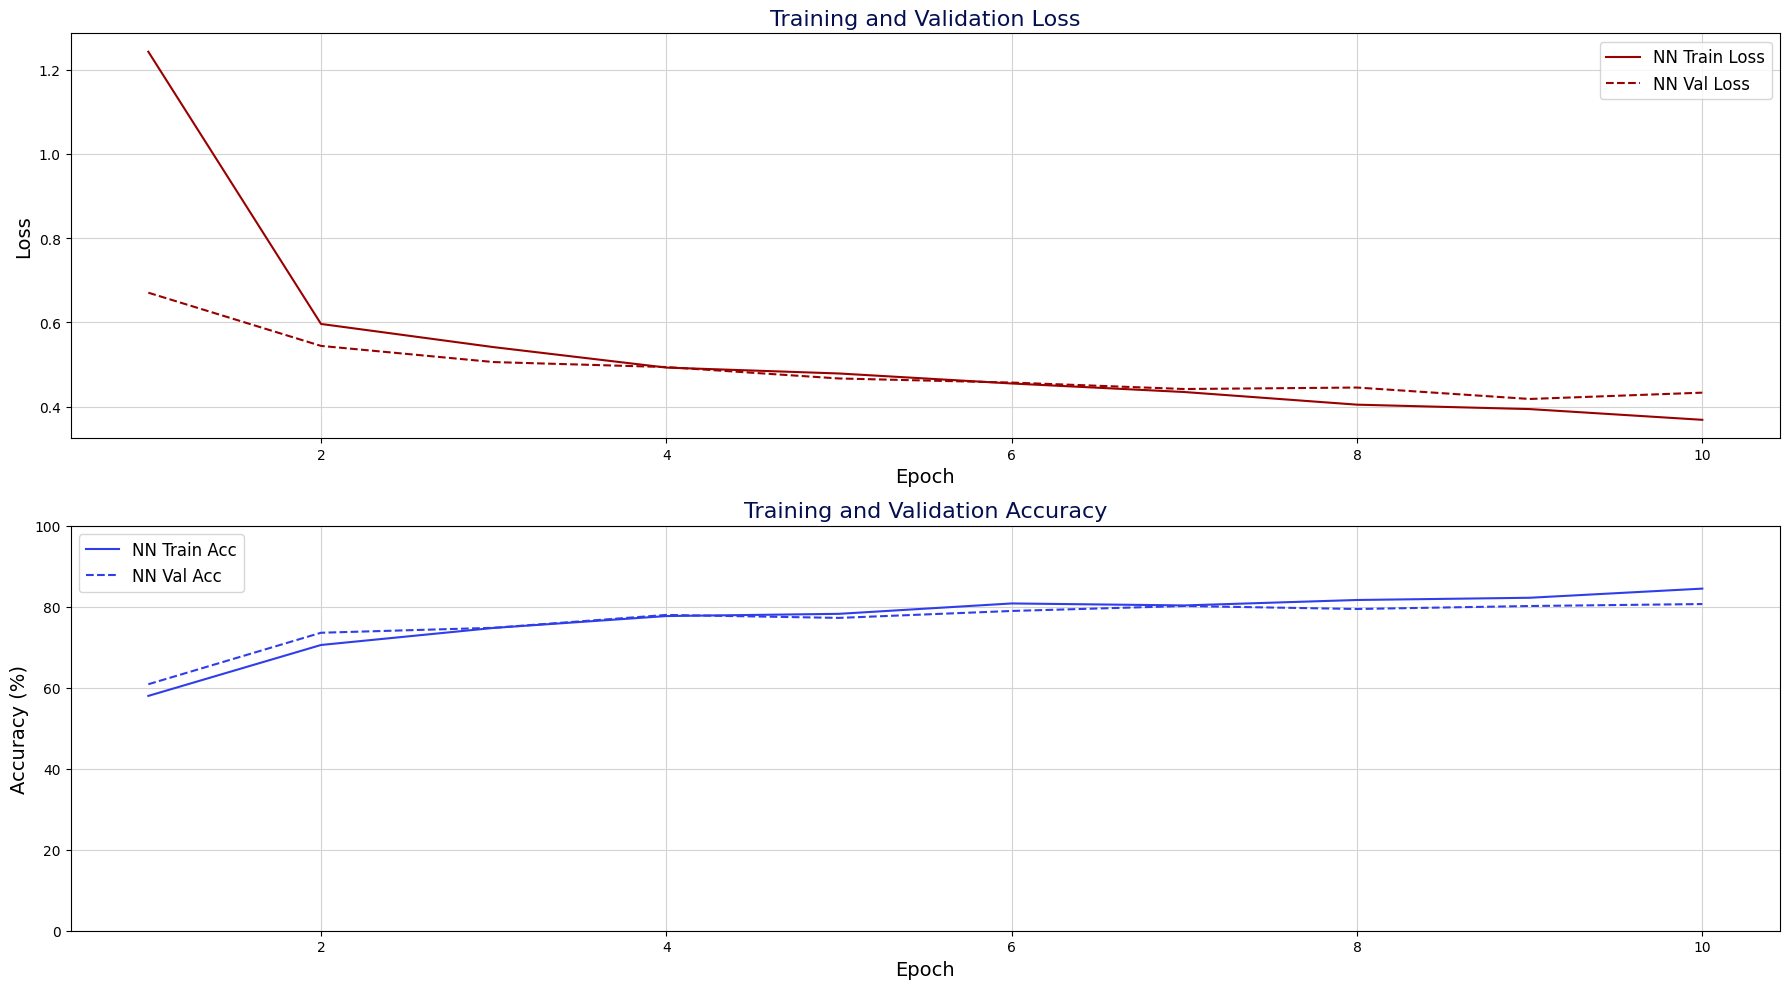

------------------------------------------------------------
🧪 Evaluating the model on the test set
------------------------------------------------------------
Test Accuracy: 70.9%


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

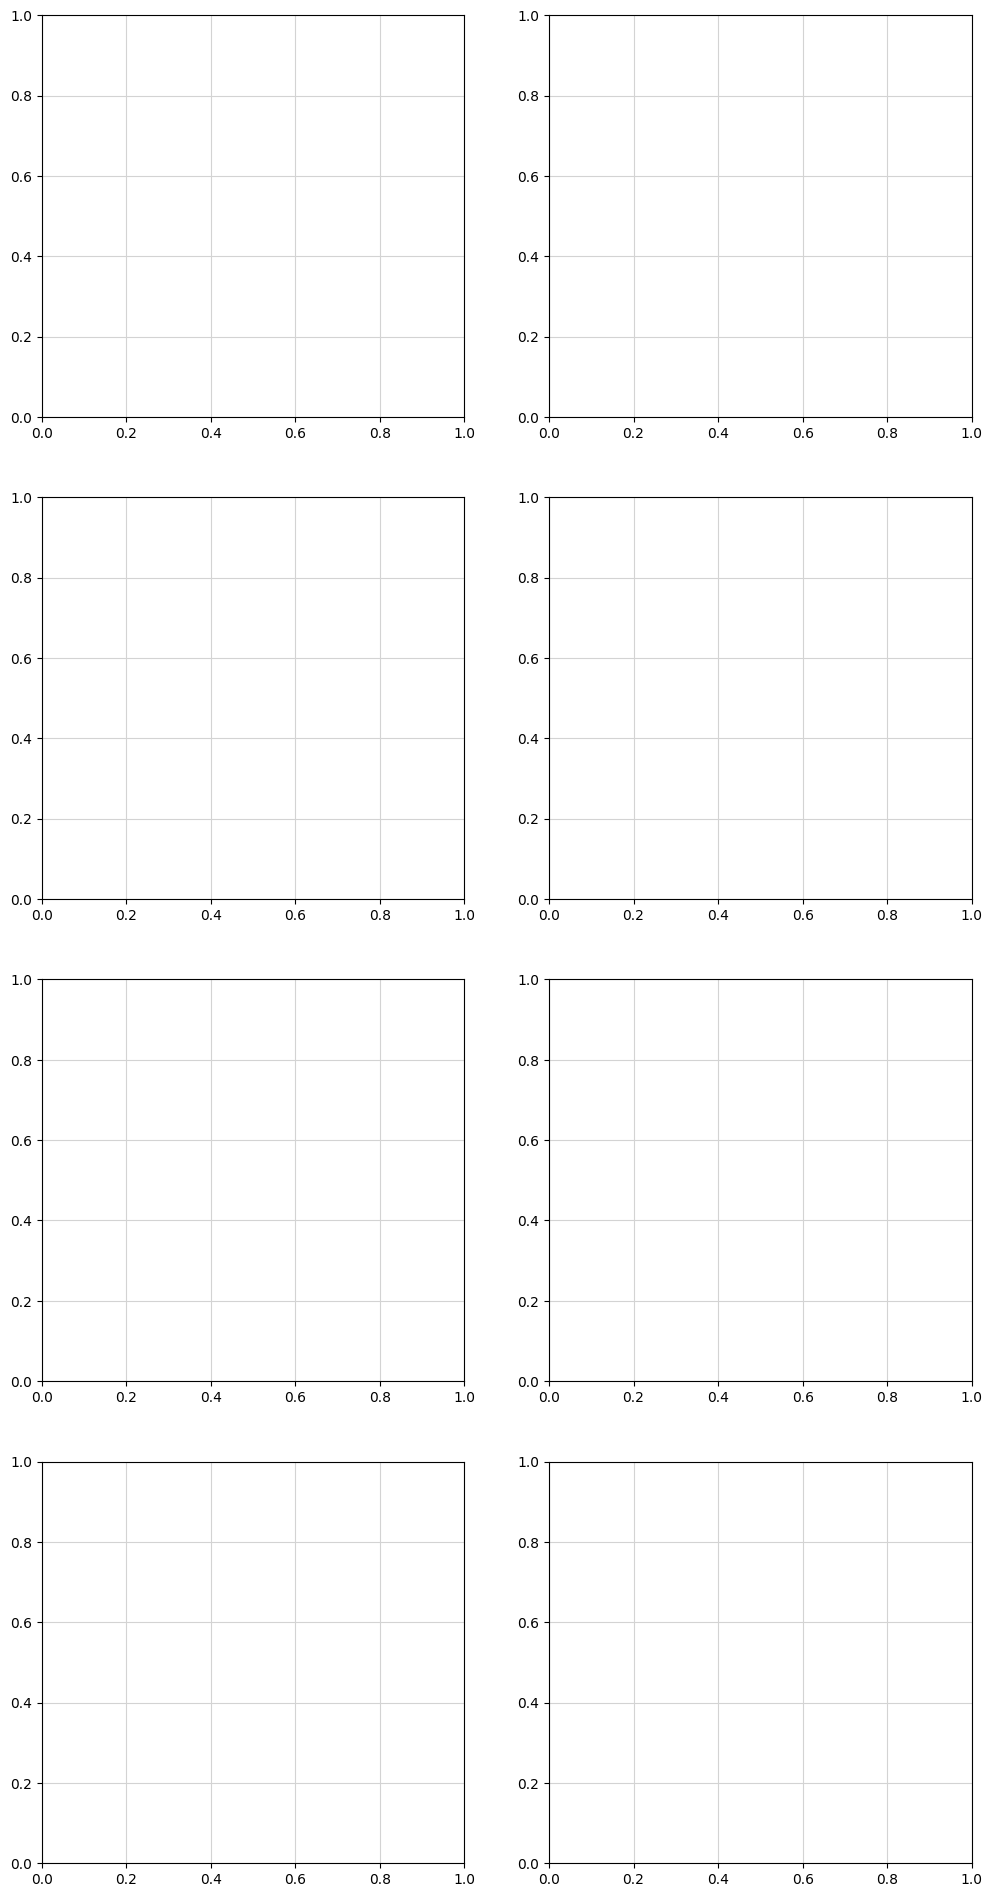

In [227]:
#####################
## MAIN ENTRY POINT #
#####################
# NOTE FOR MADS: Yes the code has comments, but it is actually written by me. Not our friend. Me

# SET FLAGS
TRAIN_BASELINE = True 
TRAIN_CNN = True
VISUALIZE_SAMPLES = True 
VISUALIZE_SALIENCY = True
VISUALIZE_FEATURE_MAPS = True 
MODEL_TRAINED_ON_NORMALIZED_DATA = False # necessary for smoothgrad to work correctly

# PATH TO THE DATA (same location as this notebook - has test and train subfolders)
data = 'data'

# SET PLOT STYLE to DTU colours and stuff (TODO: change the background there so it matches the poster's background)
set_plot_style()

# SET DEVICE
if torch.backends.mps.is_built():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# LOAD DATA FOR BASELINE (size 128)
train_loader, val_loader, test_loader = load_data(data, batch_size=64, image_size=128, validation_split=0.2)

if VISUALIZE_SAMPLES:
    visualize_samples(train_loader)

if TRAIN_BASELINE:
    nn_model = main_baseline(device, train_loader, val_loader, test_loader, num_epochs=10)

if TRAIN_CNN:
    # LOAD DATA FOR CNN (size 224)
    train_loader, val_loader, test_loader = load_data(data, batch_size=64, image_size=224, validation_split=0.2, verbose=False)
    cnn_model = main_cnn(device, train_loader, val_loader, test_loader, num_epochs=5)

if VISUALIZE_SALIENCY:
    if MODEL_TRAINED_ON_NORMALIZED_DATA:
        # SmoothGrad
        # Mean and std used during training
        mean_train = train_loader.dataset.transform.transforms[-1].mean
        std_train = train_loader.dataset.transform.transforms[-1].std
        mean_train = mean_train.to(device)
        std_train = std_train.to(device)
        visualize_saliency_maps(
        model=cnn_model,
        device=device,
        data_loader=test_loader,
        number_of_images=4,
        mean=mean_train,
        std=std_train,
        normalize_input=True  
        )

    else:
        visualize_saliency_maps(
        model=cnn_model,
        device=device,
        data_loader=test_loader,
        number_of_images=4,
        mean=None,
        std=None,
        normalize_input=False  
        )


    # GradCAM
    # TODO: Mads code

if VISUALIZE_FEATURE_MAPS:
    cut_point = 1  # choose 1 to 4 based on our architecture
    num_images_to_display = 2
    visualize_feature_maps(cnn_model, device, test_loader, cut=cut_point, num_images=num_images_to_display)